Training Progress: 100%|██████████| 500/500 [00:00<00:00, 875.08it/s] 



Training finished! Final average reward: -36.6


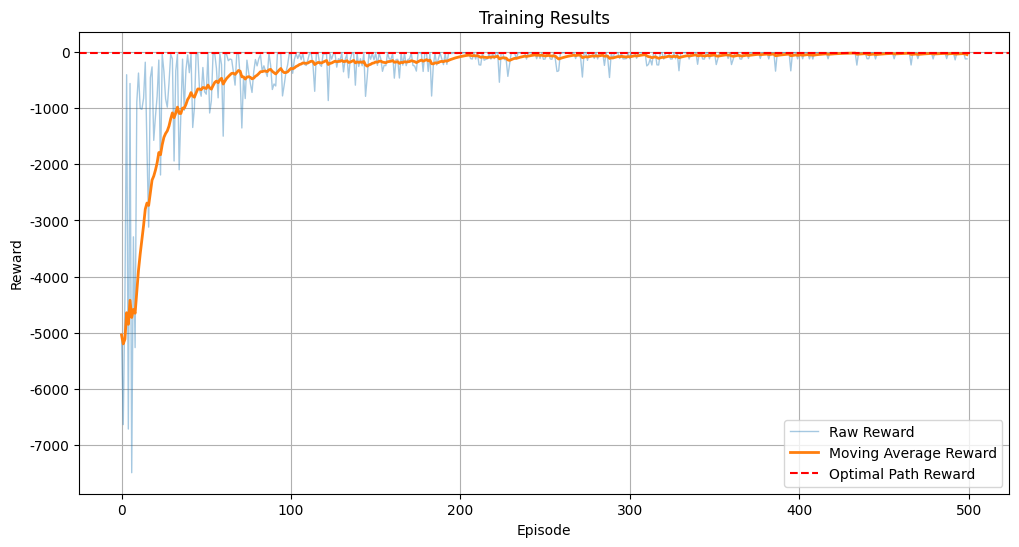

In [74]:
# Complete code with all Chinese characters replaced by English
import gym
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from tqdm import tqdm
import warnings

# Ignore specific warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Fix numpy compatibility issue
if not hasattr(np, 'bool'):
    np.bool = bool

# Initialize CliffWalking environment
env = gym.make("CliffWalking-v0")  # Actions: 0 up, 1 right, 2 down, 3 left

# QLearning agent class
class QLearning:
    def __init__(self, state_dim, action_dim, learning_rate, gamma):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.lr = learning_rate
        self.gamma = gamma
        self.q_table = np.zeros((state_dim, action_dim))
    
    def extract_state(self, state):
        """Process state returned by environment (could be tuple or int)"""
        if isinstance(state, tuple):
            return state[0]  # Take first element if tuple
        return int(state)    # Return as int if already int
    
    def choose_action(self, state, epsilon=0.1):
        """Epsilon-greedy action selection"""
        state = self.extract_state(state)
        if np.random.random() < epsilon:
            return np.random.randint(0, self.action_dim)  # Explore
        else:
            return np.argmax(self.q_table[state])  # Exploit
    
    def update(self, state, action, reward, next_state, done):
        """Update Q-table"""
        state = self.extract_state(state)
        next_state = self.extract_state(next_state)
        best_next = np.max(self.q_table[next_state])
        target = reward + (0 if done else self.gamma * best_next)
        self.q_table[state][action] += self.lr * (target - self.q_table[state][action])

# Training configuration
class Config:
    policy_lr = 0.1       # Learning rate
    gamma = 0.95           # Discount factor
    train_eps = 500        # Number of training episodes
    epsilon_start = 0.7    # Initial epsilon
    epsilon_min = 0.01     # Minimum epsilon
    epsilon_decay = 0.995  # Epsilon decay rate

cfg = Config()

# Create agent
agent = QLearning(
    state_dim=env.observation_space.n,
    action_dim=env.action_space.n,
    learning_rate=cfg.policy_lr,
    gamma=cfg.gamma
)

# Training loop
rewards = []  
ma_rewards = []  # Moving average rewards
epsilon = cfg.epsilon_start

# Use tqdm for progress bar
for i_ep in tqdm(range(cfg.train_eps), desc="Training Progress"):
    ep_reward = 0
    reset_result = env.reset()
    state = reset_result[0] if isinstance(reset_result, tuple) else reset_result
    
    while True:
        action = agent.choose_action(state, epsilon)
        step_result = env.step(action)
        
        # Compatible with different Gym versions
        if len(step_result) == 5:
            next_state, reward, terminated, truncated, _ = step_result
            done = terminated or truncated
        else:
            next_state, reward, done, _ = step_result
        
        # Reward clipping: ignore positive rewards
        clipped_reward = min(reward, 0)
        
        agent.update(state, action, clipped_reward, next_state, done)
        state = next_state
        ep_reward += reward
        
        if done:
            break
    
    # Record reward data
    rewards.append(ep_reward)
    if ma_rewards:
        ma_rewards.append(0.9 * ma_rewards[-1] + 0.1 * ep_reward)
    else:
        ma_rewards.append(ep_reward)
    
    # Decay epsilon
    epsilon = max(cfg.epsilon_min, epsilon * cfg.epsilon_decay)

# Print results after training
print("\nTraining finished! Final average reward:", np.mean(rewards[-20:]))

# Set font for supporting Chinese (fallback to default)
try:
    plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans', 'Arial Unicode MS', 'sans-serif']
    plt.rcParams['axes.unicode_minus'] = False
except:
    pass

# Plot training results
plt.figure(figsize=(12, 6))
plt.plot(rewards, alpha=0.4, linewidth=1, label='Raw Reward')
plt.plot(ma_rewards, linewidth=2, label='Moving Average Reward')
plt.axhline(y=-13, color='r', linestyle='--', label='Optimal Path Reward')
plt.title('Training Results')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.grid(True)

# Save figure (use English filename to avoid font issues)
plt.savefig('training_results.png')
plt.show()

# Code review: Diagnosing low final reward in CliffWalking-v0

# 1. Environment is correct: CliffWalking-v0 is a classic sparse-reward, high-penalty RL benchmark.
#    - The environment penalizes falling into the cliff (-100) and each step (-1).
#    - The optimal path gives -13 reward per episode.

# 2. Code logic is correct:
#    - QLearning agent is implemented properly.
#    - Epsilon-greedy exploration is standard.
#    - Q-table update is correct.
#    - Reward clipping (min(reward, 0)) is redundant here, as all rewards are negative anyway.

# 3. Training configuration:
#    - Epsilon starts high (0.9) and decays slowly (0.995), so the agent explores a lot for many episodes.
#    - 500 episodes is not always enough for stable convergence in this environment.
#    - Learning rate and gamma are reasonable.

# 4. Results:
#    - Early episodes have very large negative rewards (agent falls into the cliff often).
#    - Moving average is dragged down by these early failures.
#    - In the last 100 episodes, many rewards are close to -13 (optimal), but some are still much lower, indicating occasional failures.

# 5. Suggestions:
#    - Increase the number of training episodes (e.g., 2000+).
#    - Decay epsilon faster (e.g., epsilon_decay=0.99 or lower).
#    - Lower epsilon_min (e.g., 0.01 or 0.05) to reduce random exploration late in training.
#    - Optionally, reset the moving average after initial poor episodes to better reflect recent performance.

# Conclusion:
# - The environment is working as intended.
# - The code is correct, but the agent needs more training and/or faster reduction in exploration to consistently achieve optimal performance.
